In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU

Using TensorFlow backend.


In [2]:
data_train = pd.read_csv('air_pollution_train.csv')
data_train.head(5)

,Unnamed: 0,var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var2(t)
0,1,129.0,-16.0,-4.0,1020.0,SE,1.79,0.0,0.0,148.0
1,2,148.0,-15.0,-4.0,1020.0,SE,2.68,0.0,0.0,159.0
2,3,159.0,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0,181.0
3,4,181.0,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0,138.0
4,5,138.0,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0,109.0


In [3]:
data_train.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
label_encoder = LabelEncoder()
data_train.iloc[:,4] = label_encoder.fit_transform(data_train.iloc[:,4])

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
data_train_framed = scaler.fit_transform(data_train)

In [6]:
def series_to_supervised(data, input_lag=1, out_lag=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(input_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    for i in range(0, out_lag):
        cols.append(df.shift(-i))
        if (i == 0):
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    new_df = pd.concat(cols, axis=1)
    new_df.columns = names
    
    if (dropnan):
        new_df.dropna(inplace=True)
    
    return new_df

# Lag 1

In [7]:
data_train_framed = series_to_supervised(data=data_train_framed)

In [8]:
data_train_framed.drop(data_train_framed.columns[[9, 10, 11, 12, 13, 14, 15, 16, 17]], axis=1, inplace=True)
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1)
1,0.129779,0.278689,0.250000,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.295082,0.250000,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.360656,0.233333,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.426230,0.233333,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.426230,0.233333,0.563636,0.666667,0.009912,0.074074,0.0,0.109658


In [9]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)'
]]

y = data_train_framed.loc[:,['var9(t-1)']]

In [9]:
data_test = pd.read_csv('air_pollution_test.csv')

In [10]:
data_test.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
data_test.iloc[:,4] = label_encoder.fit_transform(data_test.iloc[:,4])

In [12]:
data_test = scaler.fit_transform(data_test)
data_test = series_to_supervised(data=data_test)

In [13]:
data_test.drop(data_test.columns[[9, 10, 11, 12, 13, 14, 15, 16, 17]], axis=1, inplace=True)
data_test.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1)
1,0.034277,0.307692,0.363636,0.456522,0.333333,0.311347,0.0,0.0,0.035768
2,0.035768,0.307692,0.363636,0.456522,0.333333,0.324530,0.0,0.0,0.078987
3,0.078987,0.307692,0.363636,0.434783,0.333333,0.333651,0.0,0.0,0.096870
4,0.096870,0.307692,0.345455,0.434783,0.333333,0.342772,0.0,0.0,0.104322
5,0.104322,0.307692,0.345455,0.434783,0.333333,0.346834,0.0,0.0,0.117735


In [14]:
x_validation = data_test.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)'
]]

y_validation = data_test.loc[:,['var9(t-1)']]

In [15]:
x_validation = np.expand_dims(x_validation, axis=2)

In [16]:
def split_data(x, y, train_size):
    x_train = x[:int(len(x)*train_size)]
    x_test = x[int(len(x)*train_size):]
    y_train = y[:int(len(y)*train_size)]
    y_test = y[int(len(y)*train_size):]
    
    return x_train, x_test, y_train, y_test

In [18]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [19]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(28030, 8) (7008, 8) (28030, 1) (7008, 1)


In [20]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

print(x_train.shape, x_test.shape)

(28030, 8, 1) (7008, 8, 1)


In [24]:
stop_noimprovement = EarlyStopping(patience=10)

model = Sequential()

model.add(LSTM(50, input_shape=(8, 1), dropout=0.2))
model.add(Dense(1))

model.compile(loss="mae", optimizer="adam")

W0704 10:10:05.889916 140586043066176 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 10:10:06.237839 140586043066176 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 10:10:06.297649 140586043066176 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 10:10:06.579945 140586043066176 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

# Test/validation with 100 epochs

In [22]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

W0704 06:54:18.346007 140625844078400 deprecation.py:323] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0704 06:54:19.326069 140625844078400 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 28030 samples, validate on 7008 samples
Epoch 1/100
 - 11s - loss: 0.0688 - val_loss: 0.0611
Epoch 2/100
 - 9s - loss: 0.0495 - val_loss: 0.0614
Epoch 3/100
 - 9s - loss: 0.0411 - val_loss: 0.0627
Epoch 4/100
 - 9s - loss: 0.0390 - val_loss: 0.0646
Epoch 5/100
 - 9s - loss: 0.0376 - val_loss: 0.0603
Epoch 6/100
 - 9s - loss: 0.0374 - val_loss: 0.0581
Epoch 7/100
 - 9s - loss: 0.0360 - val_loss: 0.0527
Epoch 8/100
 - 9s - loss: 0.0354 - val_loss: 0.0489
Epoch 9/100
 - 9s - loss: 0.0343 - val_loss: 0.0448
Epoch 10/100
 - 9s - loss: 0.0342 - val_loss: 0.0424
Epoch 11/100
 - 9s - loss: 0.0333 - val_loss: 0.0392
Epoch 12/100
 - 9s - loss: 0.0329 - val_loss: 0.0371
Epoch 13/100
 - 9s - loss: 0.0320 - val_loss: 0.0354
Epoch 14/100
 - 9s - loss: 0.0321 - val_loss: 0.0334
Epoch 15/100
 - 10s - loss: 0.0308 - val_loss: 0.0314
Epoch 16/100
 - 11s - loss: 0.0309 - val_loss: 0.0295
Epoch 17/100
 - 11s - loss: 0.0299 - val_loss: 0.0282
Epoch 18/100
 - 9s - loss: 0.0297 - val_loss: 0.0270
Ep

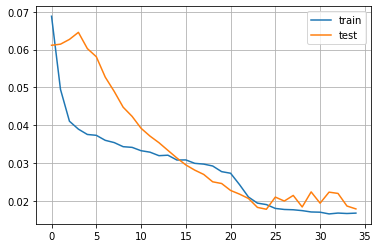

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
prediction = model.predict(x_test)

In [25]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.02857


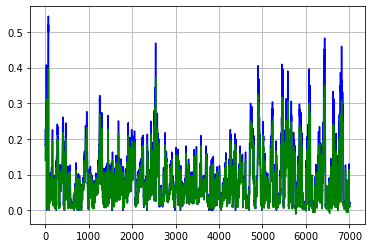

In [26]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [27]:
validation = model.predict(x_validation)

In [28]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.05653


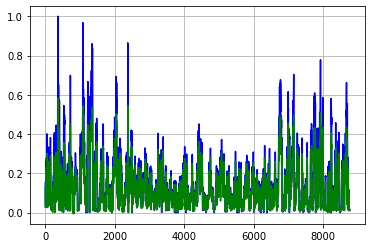

In [29]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 500 epochs

In [30]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28030 samples, validate on 7008 samples
Epoch 1/500
 - 9s - loss: 0.0163 - val_loss: 0.0221
Epoch 2/500
 - 9s - loss: 0.0159 - val_loss: 0.0206
Epoch 3/500
 - 9s - loss: 0.0161 - val_loss: 0.0232
Epoch 4/500
 - 9s - loss: 0.0167 - val_loss: 0.0201
Epoch 5/500
 - 9s - loss: 0.0163 - val_loss: 0.0175
Epoch 6/500
 - 9s - loss: 0.0162 - val_loss: 0.0202
Epoch 7/500
 - 9s - loss: 0.0162 - val_loss: 0.0197
Epoch 8/500
 - 9s - loss: 0.0161 - val_loss: 0.0196
Epoch 9/500
 - 9s - loss: 0.0162 - val_loss: 0.0191
Epoch 10/500
 - 9s - loss: 0.0159 - val_loss: 0.0197
Epoch 11/500
 - 9s - loss: 0.0160 - val_loss: 0.0202
Epoch 12/500
 - 10s - loss: 0.0161 - val_loss: 0.0209
Epoch 13/500
 - 9s - loss: 0.0159 - val_loss: 0.0202
Epoch 14/500
 - 9s - loss: 0.0160 - val_loss: 0.0182
Epoch 15/500
 - 9s - loss: 0.0160 - val_loss: 0.0213


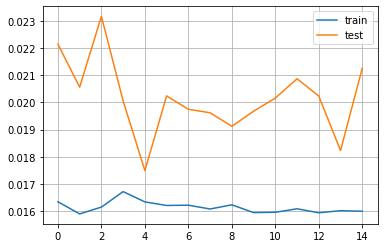

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
prediction = model.predict(x_test)

In [33]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.03131


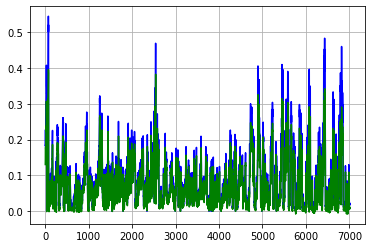

In [34]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [35]:
validation = model.predict(x_validation)

In [36]:
print('Test:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Test:
0.05945


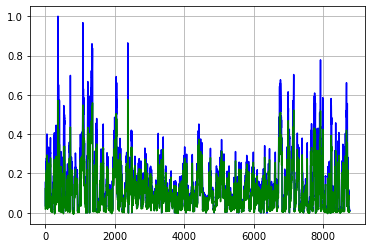

In [37]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 1000 epochs

In [38]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28030 samples, validate on 7008 samples
Epoch 1/1000
 - 9s - loss: 0.0159 - val_loss: 0.0190
Epoch 2/1000
 - 9s - loss: 0.0159 - val_loss: 0.0241
Epoch 3/1000
 - 9s - loss: 0.0160 - val_loss: 0.0207
Epoch 4/1000
 - 9s - loss: 0.0159 - val_loss: 0.0192
Epoch 5/1000
 - 9s - loss: 0.0156 - val_loss: 0.0195
Epoch 6/1000
 - 9s - loss: 0.0157 - val_loss: 0.0200
Epoch 7/1000
 - 9s - loss: 0.0156 - val_loss: 0.0214
Epoch 8/1000
 - 9s - loss: 0.0159 - val_loss: 0.0179
Epoch 9/1000
 - 9s - loss: 0.0156 - val_loss: 0.0203
Epoch 10/1000
 - 9s - loss: 0.0156 - val_loss: 0.0199
Epoch 11/1000
 - 9s - loss: 0.0158 - val_loss: 0.0199
Epoch 12/1000
 - 9s - loss: 0.0154 - val_loss: 0.0209
Epoch 13/1000
 - 9s - loss: 0.0154 - val_loss: 0.0198
Epoch 14/1000
 - 9s - loss: 0.0156 - val_loss: 0.0178
Epoch 15/1000
 - 9s - loss: 0.0155 - val_loss: 0.0203
Epoch 16/1000
 - 9s - loss: 0.0153 - val_loss: 0.0228
Epoch 17/1000
 - 9s - loss: 0.0155 - val_loss: 0.0200
Epoch 18/1000
 - 9s - loss: 0.0153 - val_l

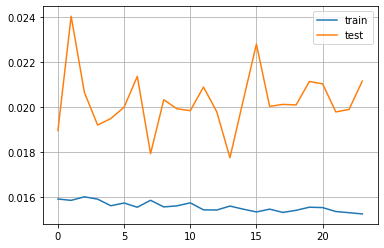

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
prediction = model.predict(x_test)

In [41]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.03213


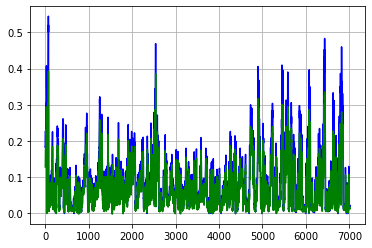

In [42]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [43]:
validation = model.predict(x_validation)

In [44]:
print('Test:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Test:
0.06021


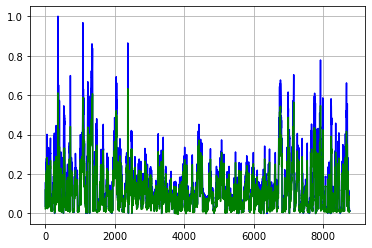

In [45]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Lag 5

In [64]:
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1)
1,0.129779,0.278689,0.250000,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.295082,0.250000,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.360656,0.233333,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.426230,0.233333,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.426230,0.233333,0.563636,0.666667,0.009912,0.074074,0.0,0.109658


In [65]:
data_train_framed = series_to_supervised(data=data_train_framed, out_lag=5)
data_train_framed.head(8)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t),...,var9(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var6(t+4),var7(t+4),var8(t+4),var9(t+4)
2,0.129779,0.278689,0.250000,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.148893,...,0.109658,0.109658,0.426230,0.216667,0.563636,0.666667,0.011433,0.111111,0.0,0.105634
3,0.148893,0.295082,0.250000,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.159960,...,0.105634,0.105634,0.426230,0.216667,0.581818,0.666667,0.014492,0.148148,0.0,0.124748
4,0.159960,0.360656,0.233333,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.182093,...,0.124748,0.124748,0.426230,0.233333,0.600000,0.666667,0.017551,0.000000,0.0,0.120724
5,0.182093,0.426230,0.233333,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.138833,...,0.120724,0.120724,0.409836,0.216667,0.600000,0.666667,0.020610,0.000000,0.0,0.132797
6,0.138833,0.426230,0.233333,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.109658,...,0.132797,0.132797,0.426230,0.233333,0.618182,0.666667,0.023669,0.000000,0.0,0.140845
7,0.109658,0.426230,0.216667,0.563636,0.666667,0.011433,0.111111,0.0,0.105634,0.105634,...,0.140845,0.140845,0.426230,0.233333,0.636364,0.666667,0.029018,0.037037,0.0,0.152918
8,0.105634,0.426230,0.216667,0.581818,0.666667,0.014492,0.148148,0.0,0.124748,0.124748,...,0.152918,0.152918,0.409836,0.233333,0.636364,0.666667,0.034367,0.000000,0.0,0.148893
9,0.124748,0.426230,0.233333,0.600000,0.666667,0.017551,0.000000,0.0,0.120724,0.120724,...,0.148893,0.148893,0.409836,0.233333,0.636364,0.666667,0.039716,0.000000,0.0,0.164990


In [66]:
data_train_framed.drop(data_train_framed.columns[[
    8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
    25,26,27,28,29,30,31,32,33,34,35,36,
    37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
]], axis=1, inplace=True)

data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t+4)
2,0.129779,0.278689,0.250000,0.527273,0.666667,0.002290,0.000000,0.0,0.105634
3,0.148893,0.295082,0.250000,0.527273,0.666667,0.003811,0.000000,0.0,0.124748
4,0.159960,0.360656,0.233333,0.545455,0.666667,0.005332,0.000000,0.0,0.120724
5,0.182093,0.426230,0.233333,0.563636,0.666667,0.008391,0.037037,0.0,0.132797
6,0.138833,0.426230,0.233333,0.563636,0.666667,0.009912,0.074074,0.0,0.140845


In [67]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)'
]]

y = data_train_framed.loc[:,['var9(t+4)']]

In [68]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [73]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

print(x_train.shape, x_test.shape)

(28026, 8, 1) (7007, 8, 1)


In [70]:
print(x.shape, x_test.shape)

(35033, 8) (7007, 8)


In [72]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(28026, 8) (7007, 8) (28026, 1) (7007, 1)


# Test/validation with 100 epochs

In [74]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28026 samples, validate on 7007 samples
Epoch 1/100
 - 9s - loss: 0.0408 - val_loss: 0.0371
Epoch 2/100
 - 12s - loss: 0.0405 - val_loss: 0.0370
Epoch 3/100
 - 11s - loss: 0.0404 - val_loss: 0.0370
Epoch 4/100
 - 11s - loss: 0.0404 - val_loss: 0.0370
Epoch 5/100
 - 10s - loss: 0.0402 - val_loss: 0.0370
Epoch 6/100
 - 10s - loss: 0.0404 - val_loss: 0.0372
Epoch 7/100
 - 11s - loss: 0.0402 - val_loss: 0.0374
Epoch 8/100
 - 10s - loss: 0.0401 - val_loss: 0.0375
Epoch 9/100
 - 10s - loss: 0.0400 - val_loss: 0.0377
Epoch 10/100
 - 10s - loss: 0.0401 - val_loss: 0.0379
Epoch 11/100
 - 11s - loss: 0.0401 - val_loss: 0.0387
Epoch 12/100
 - 11s - loss: 0.0399 - val_loss: 0.0385


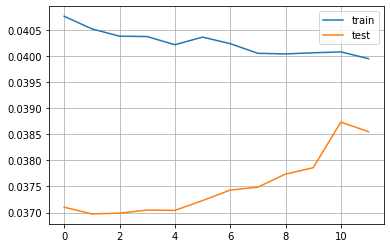

In [75]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
prediction = model.predict(x_test)

In [77]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.05704


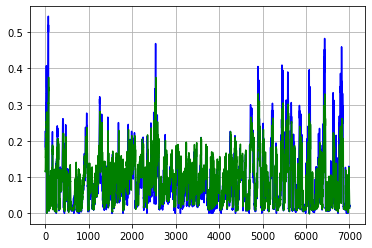

In [78]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [79]:
validation = model.predict(x_validation)

In [82]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.06507


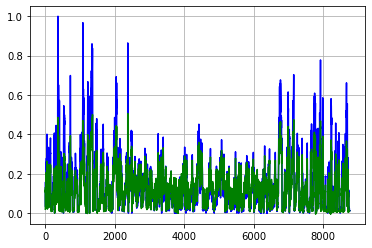

In [81]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 500 epochs

In [83]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28026 samples, validate on 7007 samples
Epoch 1/500
 - 11s - loss: 0.0400 - val_loss: 0.0380
Epoch 2/500
 - 10s - loss: 0.0399 - val_loss: 0.0380
Epoch 3/500
 - 10s - loss: 0.0399 - val_loss: 0.0383
Epoch 4/500
 - 10s - loss: 0.0399 - val_loss: 0.0387
Epoch 5/500
 - 11s - loss: 0.0398 - val_loss: 0.0382
Epoch 6/500
 - 10s - loss: 0.0397 - val_loss: 0.0380
Epoch 7/500
 - 10s - loss: 0.0398 - val_loss: 0.0381
Epoch 8/500
 - 11s - loss: 0.0399 - val_loss: 0.0381
Epoch 9/500
 - 10s - loss: 0.0397 - val_loss: 0.0377
Epoch 10/500
 - 10s - loss: 0.0397 - val_loss: 0.0381
Epoch 11/500
 - 10s - loss: 0.0396 - val_loss: 0.0383
Epoch 12/500
 - 10s - loss: 0.0397 - val_loss: 0.0383
Epoch 13/500
 - 10s - loss: 0.0396 - val_loss: 0.0388
Epoch 14/500
 - 10s - loss: 0.0396 - val_loss: 0.0388
Epoch 15/500
 - 10s - loss: 0.0395 - val_loss: 0.0380
Epoch 16/500
 - 10s - loss: 0.0395 - val_loss: 0.0382
Epoch 17/500
 - 10s - loss: 0.0395 - val_loss: 0.0382
Epoch 18/500
 - 10s - loss: 0.0395 - val_l

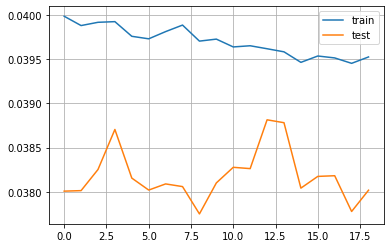

In [84]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [85]:
prediction = model.predict(x_test)

In [86]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.05634


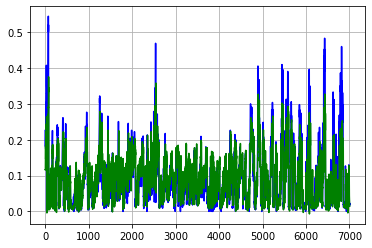

In [87]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [88]:
validation = model.predict(x_validation)

In [89]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.06707


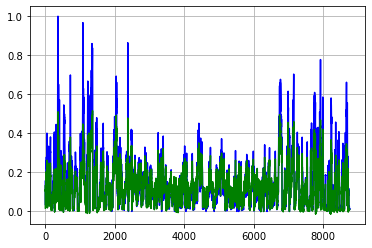

In [90]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 1000 epochs

In [91]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28026 samples, validate on 7007 samples
Epoch 1/1000
 - 10s - loss: 0.0393 - val_loss: 0.0381
Epoch 2/1000
 - 11s - loss: 0.0394 - val_loss: 0.0383
Epoch 3/1000
 - 9s - loss: 0.0394 - val_loss: 0.0379
Epoch 4/1000
 - 10s - loss: 0.0394 - val_loss: 0.0376
Epoch 5/1000
 - 10s - loss: 0.0394 - val_loss: 0.0382
Epoch 6/1000
 - 10s - loss: 0.0394 - val_loss: 0.0375
Epoch 7/1000
 - 9s - loss: 0.0393 - val_loss: 0.0380
Epoch 8/1000
 - 9s - loss: 0.0392 - val_loss: 0.0381
Epoch 9/1000
 - 10s - loss: 0.0393 - val_loss: 0.0379
Epoch 10/1000
 - 9s - loss: 0.0393 - val_loss: 0.0378
Epoch 11/1000
 - 11s - loss: 0.0392 - val_loss: 0.0380
Epoch 12/1000
 - 9s - loss: 0.0393 - val_loss: 0.0375
Epoch 13/1000
 - 10s - loss: 0.0393 - val_loss: 0.0374
Epoch 14/1000
 - 10s - loss: 0.0391 - val_loss: 0.0377
Epoch 15/1000
 - 10s - loss: 0.0392 - val_loss: 0.0377
Epoch 16/1000
 - 10s - loss: 0.0392 - val_loss: 0.0374
Epoch 17/1000
 - 10s - loss: 0.0392 - val_loss: 0.0374
Epoch 18/1000
 - 9s - loss: 0.

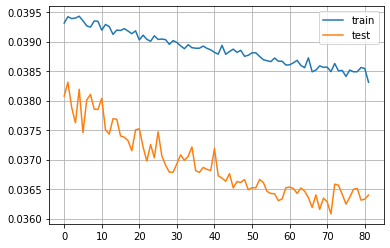

In [92]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
prediction = model.predict(x_test)

In [94]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.05475


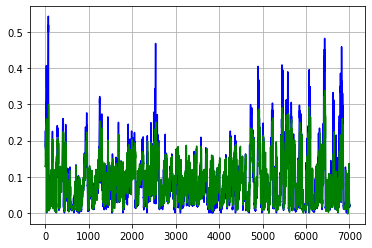

In [95]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [96]:
validation = model.predict(x_validation)

In [97]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.07375


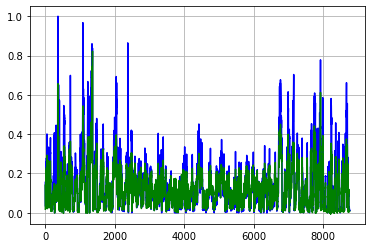

In [98]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Lag 10

In [17]:
data_train_framed = series_to_supervised(data=data_train_framed, out_lag=10)
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t),...,var9(t+8),var1(t+9),var2(t+9),var3(t+9),var4(t+9),var5(t+9),var6(t+9),var7(t+9),var8(t+9),var9(t+9)
2,0.129779,0.278689,0.250000,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.148893,...,0.140845,0.140845,0.426230,0.233333,0.636364,0.666667,0.029018,0.037037,0.0,0.152918
3,0.148893,0.295082,0.250000,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.159960,...,0.152918,0.152918,0.409836,0.233333,0.636364,0.666667,0.034367,0.000000,0.0,0.148893
4,0.159960,0.360656,0.233333,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.182093,...,0.148893,0.148893,0.409836,0.233333,0.636364,0.666667,0.039716,0.000000,0.0,0.164990
5,0.182093,0.426230,0.233333,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.138833,...,0.164990,0.164990,0.409836,0.233333,0.618182,0.666667,0.046586,0.000000,0.0,0.158954
6,0.138833,0.426230,0.233333,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.109658,...,0.158954,0.158954,0.393443,0.233333,0.618182,0.666667,0.053456,0.000000,0.0,0.154930


In [18]:
data_train_framed.drop(data_train_framed.columns[[
    8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
    38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,
    68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
]], axis=1, inplace=True)

data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t+9)
2,0.129779,0.278689,0.250000,0.527273,0.666667,0.002290,0.000000,0.0,0.152918
3,0.148893,0.295082,0.250000,0.527273,0.666667,0.003811,0.000000,0.0,0.148893
4,0.159960,0.360656,0.233333,0.545455,0.666667,0.005332,0.000000,0.0,0.164990
5,0.182093,0.426230,0.233333,0.563636,0.666667,0.008391,0.037037,0.0,0.158954
6,0.138833,0.426230,0.233333,0.563636,0.666667,0.009912,0.074074,0.0,0.154930


In [19]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)'
]]

y = data_train_framed.loc[:,['var9(t+9)']]

In [20]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [21]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

print(x_train.shape, x_test.shape)

(28022, 8, 1) (7006, 8, 1)


# Test/validation with 100 epochs

In [25]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

W0704 10:10:21.290507 140586043066176 deprecation.py:323] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0704 10:10:21.842179 140586043066176 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 28022 samples, validate on 7006 samples
Epoch 1/100
 - 8s - loss: 0.0698 - val_loss: 0.0641
Epoch 2/100
 - 6s - loss: 0.0687 - val_loss: 0.0622
Epoch 3/100
 - 6s - loss: 0.0681 - val_loss: 0.0645
Epoch 4/100
 - 5s - loss: 0.0647 - val_loss: 0.0573
Epoch 5/100
 - 5s - loss: 0.0617 - val_loss: 0.0645
Epoch 6/100
 - 6s - loss: 0.0613 - val_loss: 0.0688
Epoch 7/100
 - 5s - loss: 0.0603 - val_loss: 0.0692
Epoch 8/100
 - 5s - loss: 0.0592 - val_loss: 0.0720
Epoch 9/100
 - 5s - loss: 0.0592 - val_loss: 0.0708
Epoch 10/100
 - 5s - loss: 0.0592 - val_loss: 0.0691
Epoch 11/100
 - 6s - loss: 0.0588 - val_loss: 0.0695
Epoch 12/100
 - 5s - loss: 0.0585 - val_loss: 0.0727
Epoch 13/100
 - 6s - loss: 0.0584 - val_loss: 0.0697
Epoch 14/100
 - 5s - loss: 0.0588 - val_loss: 0.0731


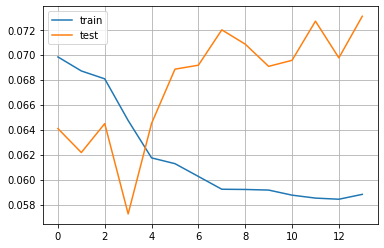

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
prediction = model.predict(x_test)

In [31]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.09235


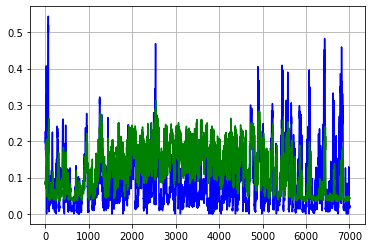

In [32]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [33]:
validation = model.predict(x_validation)

In [34]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.11151


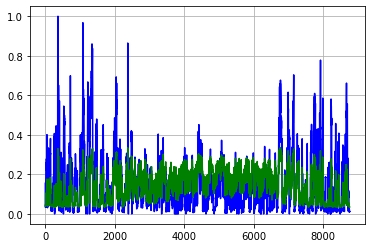

In [35]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 500 epochs

In [36]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28022 samples, validate on 7006 samples
Epoch 1/500
 - 5s - loss: 0.0579 - val_loss: 0.0721
Epoch 2/500
 - 5s - loss: 0.0584 - val_loss: 0.0706
Epoch 3/500
 - 5s - loss: 0.0576 - val_loss: 0.0674
Epoch 4/500
 - 6s - loss: 0.0575 - val_loss: 0.0713
Epoch 5/500
 - 6s - loss: 0.0576 - val_loss: 0.0683
Epoch 6/500
 - 5s - loss: 0.0574 - val_loss: 0.0689
Epoch 7/500
 - 5s - loss: 0.0572 - val_loss: 0.0675
Epoch 8/500
 - 5s - loss: 0.0569 - val_loss: 0.0651
Epoch 9/500
 - 5s - loss: 0.0567 - val_loss: 0.0629
Epoch 10/500
 - 6s - loss: 0.0567 - val_loss: 0.0624
Epoch 11/500
 - 5s - loss: 0.0567 - val_loss: 0.0631
Epoch 12/500
 - 5s - loss: 0.0562 - val_loss: 0.0615
Epoch 13/500
 - 5s - loss: 0.0562 - val_loss: 0.0608
Epoch 14/500
 - 5s - loss: 0.0561 - val_loss: 0.0584
Epoch 15/500
 - 5s - loss: 0.0560 - val_loss: 0.0606
Epoch 16/500
 - 5s - loss: 0.0560 - val_loss: 0.0574
Epoch 17/500
 - 6s - loss: 0.0559 - val_loss: 0.0560
Epoch 18/500
 - 5s - loss: 0.0556 - val_loss: 0.0580
Epoch 

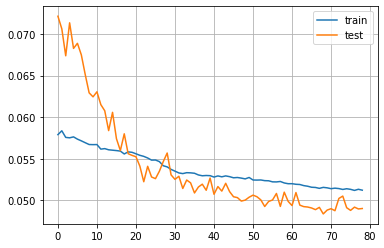

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
prediction = model.predict(x_test)

In [39]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.06828


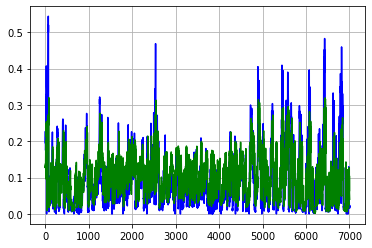

In [40]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [41]:
validation = model.predict(x_validation)

In [42]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.08514


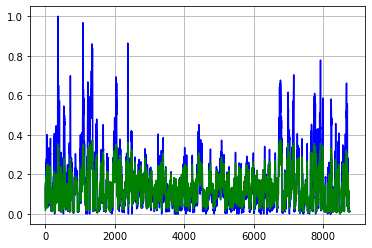

In [43]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test/validation with 1000 epochs

In [44]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 28022 samples, validate on 7006 samples
Epoch 1/1000
 - 5s - loss: 0.0512 - val_loss: 0.0491
Epoch 2/1000
 - 5s - loss: 0.0512 - val_loss: 0.0485
Epoch 3/1000
 - 5s - loss: 0.0511 - val_loss: 0.0487
Epoch 4/1000
 - 5s - loss: 0.0512 - val_loss: 0.0490
Epoch 5/1000
 - 5s - loss: 0.0511 - val_loss: 0.0493
Epoch 6/1000
 - 6s - loss: 0.0510 - val_loss: 0.0487
Epoch 7/1000
 - 6s - loss: 0.0512 - val_loss: 0.0496
Epoch 8/1000
 - 5s - loss: 0.0509 - val_loss: 0.0478
Epoch 9/1000
 - 5s - loss: 0.0509 - val_loss: 0.0486
Epoch 10/1000
 - 5s - loss: 0.0509 - val_loss: 0.0488
Epoch 11/1000
 - 5s - loss: 0.0509 - val_loss: 0.0487
Epoch 12/1000
 - 5s - loss: 0.0509 - val_loss: 0.0478
Epoch 13/1000
 - 5s - loss: 0.0509 - val_loss: 0.0485
Epoch 14/1000
 - 5s - loss: 0.0509 - val_loss: 0.0478
Epoch 15/1000
 - 5s - loss: 0.0509 - val_loss: 0.0481
Epoch 16/1000
 - 5s - loss: 0.0508 - val_loss: 0.0484
Epoch 17/1000
 - 5s - loss: 0.0509 - val_loss: 0.0483
Epoch 18/1000
 - 5s - loss: 0.0509 - val_l

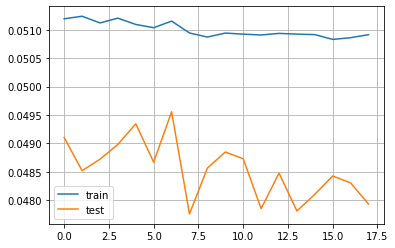

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
prediction = model.predict(x_test)

In [47]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.06791


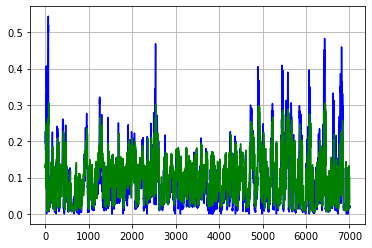

In [48]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [49]:
validation = model.predict(x_validation)

In [50]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.0882


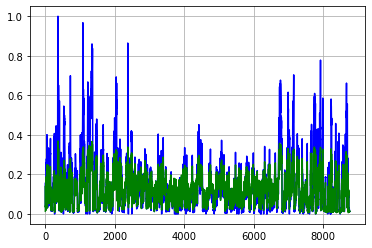

In [51]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)